In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics, preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, KFold, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, make_scorer, precision_score, recall_score, log_loss, mean_squared_error, brier_score_loss
import xgboost
from xgboost import XGBClassifier, plot_importance
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier, StackingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.feature_selection import SelectFromModel
import random

In [85]:
# Setting seeds for reproducibility
random_seed = 42
np.random.seed(random_seed)
random.seed(random_seed)


In [86]:
men_tournament = pd.read_csv("/kaggle/input/march-machine-learning-mania-2024/MNCAATourneyDetailedResults.csv")
men_tournament.drop(['NumOT', 'WLoc'], axis=1, inplace=True)
men_tournament["set"] = 1
men_seeds = pd.read_csv("/kaggle/input/march-machine-learning-mania-2024/MNCAATourneySeeds.csv")
men_seeds["Seed"] = men_seeds["Seed"].apply(lambda x: int(x[1:3]))
men_regular = pd.read_csv("/kaggle/input/march-machine-learning-mania-2024/MRegularSeasonDetailedResults.csv")
men_regular.drop(['NumOT', 'WLoc'], axis=1, inplace=True)
men_regular["set"] = 0

men_box = pd.concat([men_tournament, men_regular], ignore_index=True)
men_box["gender"] = 1


In [87]:
w_df = men_box.loc[:, ['Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WFGM',
       'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO',
       'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA',
       'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF', 'set', 'gender']]
w_df.columns = [
    'Season', 'DayNum', 
    'ATeamID', 'AScore', 'BTeamID', 'BScore', 
    'AFGM', 'AFGA', 'AFGM3', 'AFGA3', 'AFTM', 'AFTA', 'AOR', 'ADR', 'AAst', 'ATO', 'AStl', 'ABlk', 'APF', 
    'BFGM', 'BFGA', 'BFGM3', 'BFGA3', 'BFTM', 'BFTA', 'BOR', 'BDR', 'BAst', 'BTO', 'BStl', 'BBlk', 'BPF', 
    'Set', 'Gender'
]

l_df = men_box.loc[:, ['Season', 'DayNum', 'LTeamID', 'LScore', 'WTeamID', 'WScore', 'LFGM',
       'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO',
       'LStl', 'LBlk', 'LPF', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA',
       'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'set', 'gender']]
l_df.columns = [
    'Season', 'DayNum', 
    'ATeamID', 'AScore', 'BTeamID', 'BScore', 
    'AFGM', 'AFGA', 'AFGM3', 'AFGA3', 'AFTM', 'AFTA', 'AOR', 'ADR', 'AAst', 'ATO', 'AStl', 'ABlk', 'APF', 
    'BFGM', 'BFGA', 'BFGM3', 'BFGA3', 'BFTM', 'BFTA', 'BOR', 'BDR', 'BAst', 'BTO', 'BStl', 'BBlk', 'BPF', 
    'Set', 'Gender'
]

all_box = pd.concat([w_df, l_df], axis=0)
all_box['AWin'] = (all_box['AScore'] > all_box['BScore']).astype(int)
all_box['ALoss'] = (all_box['AScore'] < all_box['BScore']).astype(int)
all_box['BWin'] = (all_box['AScore'] < all_box['BScore']).astype(int)
all_box['BLoss'] = (all_box['AScore'] > all_box['BScore']).astype(int)

In [88]:
all_box['AWins'] = all_box.groupby(['Season', 'ATeamID'])['AWin'].transform('sum')
all_box['ALosses'] = all_box.groupby(['Season', 'ATeamID'])['ALoss'].transform('sum')
all_box['AGames'] = all_box["AWins"] + all_box["ALosses"]
all_box['ATotalPts'] = all_box.groupby(['Season', 'ATeamID'])['AScore'].transform('sum')
all_box["ATotalFGM"] = all_box.groupby(['Season', 'ATeamID'])['AFGM'].transform('sum')
all_box["ATotalFGA"] = all_box.groupby(['Season', 'ATeamID'])['AFGA'].transform('sum')
all_box["ATotal3PM"] = all_box.groupby(['Season', 'ATeamID'])['AFGM3'].transform('sum')
all_box["ATotal3PA"] = all_box.groupby(['Season', 'ATeamID'])['AFGA3'].transform('sum')
all_box["ATotalFTM"] = all_box.groupby(['Season', 'ATeamID'])['AFTM'].transform('sum')
all_box["ATotalFTA"] = all_box.groupby(['Season', 'ATeamID'])['AFTA'].transform('sum')
all_box["ATotalOR"] = all_box.groupby(['Season', 'ATeamID'])['AOR'].transform('sum')
all_box["ATotalDR"] = all_box.groupby(['Season', 'ATeamID'])['ADR'].transform('sum')
all_box["ATotalAst"] = all_box.groupby(['Season', 'ATeamID'])['AAst'].transform('sum')
all_box["ATotalTO"] = all_box.groupby(['Season', 'ATeamID'])['ATO'].transform('sum')
all_box["ATotalStl"] = all_box.groupby(['Season', 'ATeamID'])['AStl'].transform('sum')
all_box["ATotalBlk"] = all_box.groupby(['Season', 'ATeamID'])['ABlk'].transform('sum')
all_box["ATotalPf"] = all_box.groupby(['Season', 'ATeamID'])['APF'].transform('sum')

all_box['BWins'] = all_box.groupby(['Season', 'BTeamID'])['BWin'].transform('sum')
all_box['BLosses'] = all_box.groupby(['Season', 'BTeamID'])['BLoss'].transform('sum')
all_box['BGames'] = all_box["BWins"] + all_box["BLosses"]
all_box['BTotalPts'] = all_box.groupby(['Season', 'BTeamID'])['BScore'].transform('sum')
all_box["BTotalFGM"] = all_box.groupby(['Season', 'BTeamID'])['BFGM'].transform('sum')
all_box["BTotalFGA"] = all_box.groupby(['Season', 'BTeamID'])['BFGA'].transform('sum')
all_box["BTotal3PM"] = all_box.groupby(['Season', 'BTeamID'])['BFGM3'].transform('sum')
all_box["BTotal3PA"] = all_box.groupby(['Season', 'BTeamID'])['BFGA3'].transform('sum')
all_box["BTotalFTM"] = all_box.groupby(['Season', 'BTeamID'])['BFTM'].transform('sum')
all_box["BTotalFTA"] = all_box.groupby(['Season', 'BTeamID'])['BFTA'].transform('sum')
all_box["BTotalOR"] = all_box.groupby(['Season', 'BTeamID'])['BOR'].transform('sum')
all_box["BTotalDR"] = all_box.groupby(['Season', 'BTeamID'])['BDR'].transform('sum')
all_box["BTotalAst"] = all_box.groupby(['Season', 'BTeamID'])['BAst'].transform('sum')
all_box["BTotalTO"] = all_box.groupby(['Season', 'BTeamID'])['BTO'].transform('sum')
all_box["BTotalStl"] = all_box.groupby(['Season', 'BTeamID'])['BStl'].transform('sum')
all_box["BTotalBlk"] = all_box.groupby(['Season', 'BTeamID'])['BBlk'].transform('sum')
all_box["BTotalPf"] = all_box.groupby(['Season', 'BTeamID'])['BPF'].transform('sum')

In [89]:
all_box['AOppWins'] = all_box.groupby(['Season', 'BTeamID'])['BWin'].transform('sum')
all_box['AOppLosses'] = all_box.groupby(['Season', 'BTeamID'])['BLoss'].transform('sum')
all_box['BOppWins'] = all_box.groupby(['Season', 'BTeamID'])['AWin'].transform('sum')
all_box['BOppLosses'] = all_box.groupby(['Season', 'BTeamID'])['ALoss'].transform('sum')
all_box['AOppGames'] = all_box["BOppWins"] + all_box["BOppLosses"]
all_box['BOppGames'] = all_box["BOppWins"] + all_box["BOppLosses"]

all_box['AOppPts'] = all_box.groupby(['Season', 'ATeamID'])['BScore'].transform('sum')
all_box["AOppFGM"] = all_box.groupby(['Season', 'ATeamID'])['BFGM'].transform('sum')
all_box["AOppFGA"] = all_box.groupby(['Season', 'ATeamID'])['BFGA'].transform('sum')
all_box["AOpp3PM"] = all_box.groupby(['Season', 'ATeamID'])['BFGM3'].transform('sum')
all_box["AOpp3PA"] = all_box.groupby(['Season', 'ATeamID'])['BFGA3'].transform('sum')
all_box["AOppFTM"] = all_box.groupby(['Season', 'ATeamID'])['BFTM'].transform('sum')
all_box["AOppFTA"] = all_box.groupby(['Season', 'ATeamID'])['BFTA'].transform('sum')
all_box["AOppOR"] = all_box.groupby(['Season', 'ATeamID'])['BOR'].transform('sum')
all_box["AOppDR"] = all_box.groupby(['Season', 'ATeamID'])['BDR'].transform('sum')
all_box["AOppAst"] = all_box.groupby(['Season', 'ATeamID'])['BAst'].transform('sum')
all_box["AOppTO"] = all_box.groupby(['Season', 'ATeamID'])['BTO'].transform('sum')
all_box["AOppStl"] = all_box.groupby(['Season', 'ATeamID'])['BStl'].transform('sum')
all_box["AOppBlk"] = all_box.groupby(['Season', 'ATeamID'])['BBlk'].transform('sum')
all_box["AOppPf"] = all_box.groupby(['Season', 'ATeamID'])['BPF'].transform('sum')

all_box['BOppPts'] = all_box.groupby(['Season', 'BTeamID'])['AScore'].transform('sum')
all_box["BOppFGM"] = all_box.groupby(['Season', 'BTeamID'])['AFGM'].transform('sum')
all_box["BOppFGA"] = all_box.groupby(['Season', 'BTeamID'])['AFGA'].transform('sum')
all_box["BOpp3PM"] = all_box.groupby(['Season', 'BTeamID'])['AFGM3'].transform('sum')
all_box["BOpp3PA"] = all_box.groupby(['Season', 'BTeamID'])['AFGA3'].transform('sum')
all_box["BOppFTM"] = all_box.groupby(['Season', 'BTeamID'])['AFTM'].transform('sum')
all_box["BOppFTA"] = all_box.groupby(['Season', 'BTeamID'])['AFTA'].transform('sum')
all_box["BOppOR"] = all_box.groupby(['Season', 'BTeamID'])['AOR'].transform('sum')
all_box["BOppDR"] = all_box.groupby(['Season', 'BTeamID'])['ADR'].transform('sum')
all_box["BOppAst"] = all_box.groupby(['Season', 'BTeamID'])['AAst'].transform('sum')
all_box["BOppTO"] = all_box.groupby(['Season', 'BTeamID'])['ATO'].transform('sum')
all_box["BOppStl"] = all_box.groupby(['Season', 'BTeamID'])['AStl'].transform('sum')
all_box["BOppBlk"] = all_box.groupby(['Season', 'BTeamID'])['ABlk'].transform('sum')
all_box["BOppPf"] = all_box.groupby(['Season', 'BTeamID'])['APF'].transform('sum')

In [90]:
all_box["ATotalPoss"] =  all_box["ATotalFGA"] + 0.44 * all_box["ATotalFTA"] - all_box["ATotalOR"] + all_box["ATotalTO"]
all_box["BTotalPoss"] =  all_box["BTotalFGA"] + 0.44 * all_box["BTotalFTA"] - all_box["BTotalOR"] + all_box["BTotalTO"]
all_box["AOppPoss"] =  all_box["AOppFGA"] + 0.44 * all_box["AOppFTA"] - all_box["AOppOR"] + all_box["AOppTO"]
all_box["BOppPoss"] =  all_box["BOppFGA"] + 0.44 * all_box["BOppFTA"] - all_box["BOppOR"] + all_box["BOppTO"]

In [91]:
df = pd.DataFrame()
df["Season"] = all_box["Season"]
df["Gender"] = all_box["Gender"]
df["TeamA"] = all_box["ATeamID"]
df["TeamB"] = all_box["BTeamID"]
df["AWRatio"] = all_box["AWins"] / all_box["AGames"]
df["BWRatio"] = all_box["BWins"] / all_box["BGames"]
df["AEFG"] = (all_box["ATotalFGM"] + 0.5 * all_box["ATotal3PM"]) / all_box["ATotalFGA"]
df["BEFG"] = (all_box["BTotalFGM"] + 0.5 * all_box["BTotal3PM"]) / all_box["BTotalFGA"]
df["AOppEFG"] = (all_box["AOppFGM"] + 0.5 * all_box["AOpp3PM"]) / all_box["AOppFGA"]
df["BOppEFG"] = (all_box["BOppFGM"] + 0.5 * all_box["BOpp3PM"]) / all_box["BOppFGA"]
df["APPP"] = all_box["ATotalPts"] / all_box["ATotalPoss"]
df["BPPP"] = all_box["BTotalPts"] / all_box["BTotalPoss"]
df["AOppPPP"] = all_box["AOppPts"] / all_box["AOppPoss"]
df["BOppPPP"] = all_box["BOppPts"] / all_box["BOppPoss"]
df["ATS"] = all_box["ATotalPts"] / (2 * (all_box["ATotalFGA"] + 0.475 * all_box["ATotalFTA"]))
df["BTS"] = all_box["BTotalPts"] / (2 * (all_box["BTotalFGA"] + 0.475 * all_box["BTotalFTA"]))
df["AOppTS"] = all_box["AOppPts"] / (2 * (all_box["AOppFGA"] + 0.475 * all_box["AOppFTA"]))
df["BOppTS"] = all_box["BOppPts"] / (2 * (all_box["BOppFGA"] + 0.475 * all_box["BOppFTA"]))
df["AORTG"] = 100 * all_box["ATotalPts"] / all_box["ATotalPoss"]
df["BORTG"] = 100 * all_box["BTotalPts"] / all_box["BTotalPoss"]
df["ADRTG"] = 100 * all_box["AOppPts"] / all_box["AOppPoss"]
df["BDRTG"] = 100 * all_box["BOppPts"] / all_box["BOppPoss"]
df["ATOVPct"] = all_box["ATotalTO"] / (all_box["ATotalFGA"] + 0.475 * all_box["ATotalFTA"] + all_box["ATotalTO"])
df["BTOVPct"] = all_box["BTotalTO"] / (all_box["BTotalFGA"] + 0.475 * all_box["BTotalFTA"] + all_box["BTotalTO"])
df["AOppTOV"] = all_box["AOppTO"] / (all_box["AOppFGA"] + 0.475 * all_box["AOppFTA"] + all_box["AOppTO"])
df["BOppTOV"] = all_box["BOppTO"] / (all_box["BOppFGA"] + 0.475 * all_box["BOppFTA"] + all_box["BOppTO"])
df["AORPct"] = all_box["ATotalOR"] / (all_box["ATotalOR"] + all_box["AOppDR"])
df["BORPct"] = all_box["BTotalOR"] / (all_box["BTotalOR"] + all_box["BOppDR"])
df["ADRPct"] = all_box["ATotalDR"] / (all_box["ATotalDR"] + all_box["AOppOR"])
df["BDRPct"] = all_box["BTotalDR"] / (all_box["BTotalDR"] + all_box["BOppOR"])
df["AFTR"] = all_box["ATotalFTA"] / all_box["ATotalFGA"]
df["BFTR"] = all_box["BTotalFTA"] / all_box["BTotalFGA"]
df["AOppFTR"] = all_box["AOppFTA"] / all_box["AOppFGA"]
df["BOppFTR"] = all_box["BOppFTA"] / all_box["BOppFGA"]
df["4fODiff"] = (0.4 * (df["AEFG"] - df["BEFG"])) - (0.25 * (df["ATOVPct"] - df["BTOVPct"])) + (0.2 * (df["AORPct"] - df["BORPct"])) + (0.15 * (df["AFTR"] - df["BFTR"]))
df["4fDDiff"] = -(0.4 * (df["AOppEFG"] - df["BOppEFG"])) + (0.25 * (df["AOppTOV"] - df["BOppTOV"])) + (0.2 * (df["ADRPct"] - df["BDRPct"])) - (0.15 * (df["AOppFTR"] - df["BOppFTR"]))
df["4F"] = df["4fODiff"] - df["4fDDiff"]
df.drop(["4fODiff", "4fDDiff"], axis=1, inplace=True)
df["AWin"] = all_box['AWin']
df["Set"] = all_box["Set"]

In [92]:
df = pd.merge(df, men_seeds, how='left', left_on=['Season', 'TeamA'], right_on=['Season', 'TeamID']).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedA'})
df = pd.merge(df, men_seeds, how='left', left_on=['Season', 'TeamB'], right_on=['Season', 'TeamID']).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedB'})
df.loc[:, ["SeedA", "SeedB"]] = df[["SeedA", "SeedB"]].fillna(0)

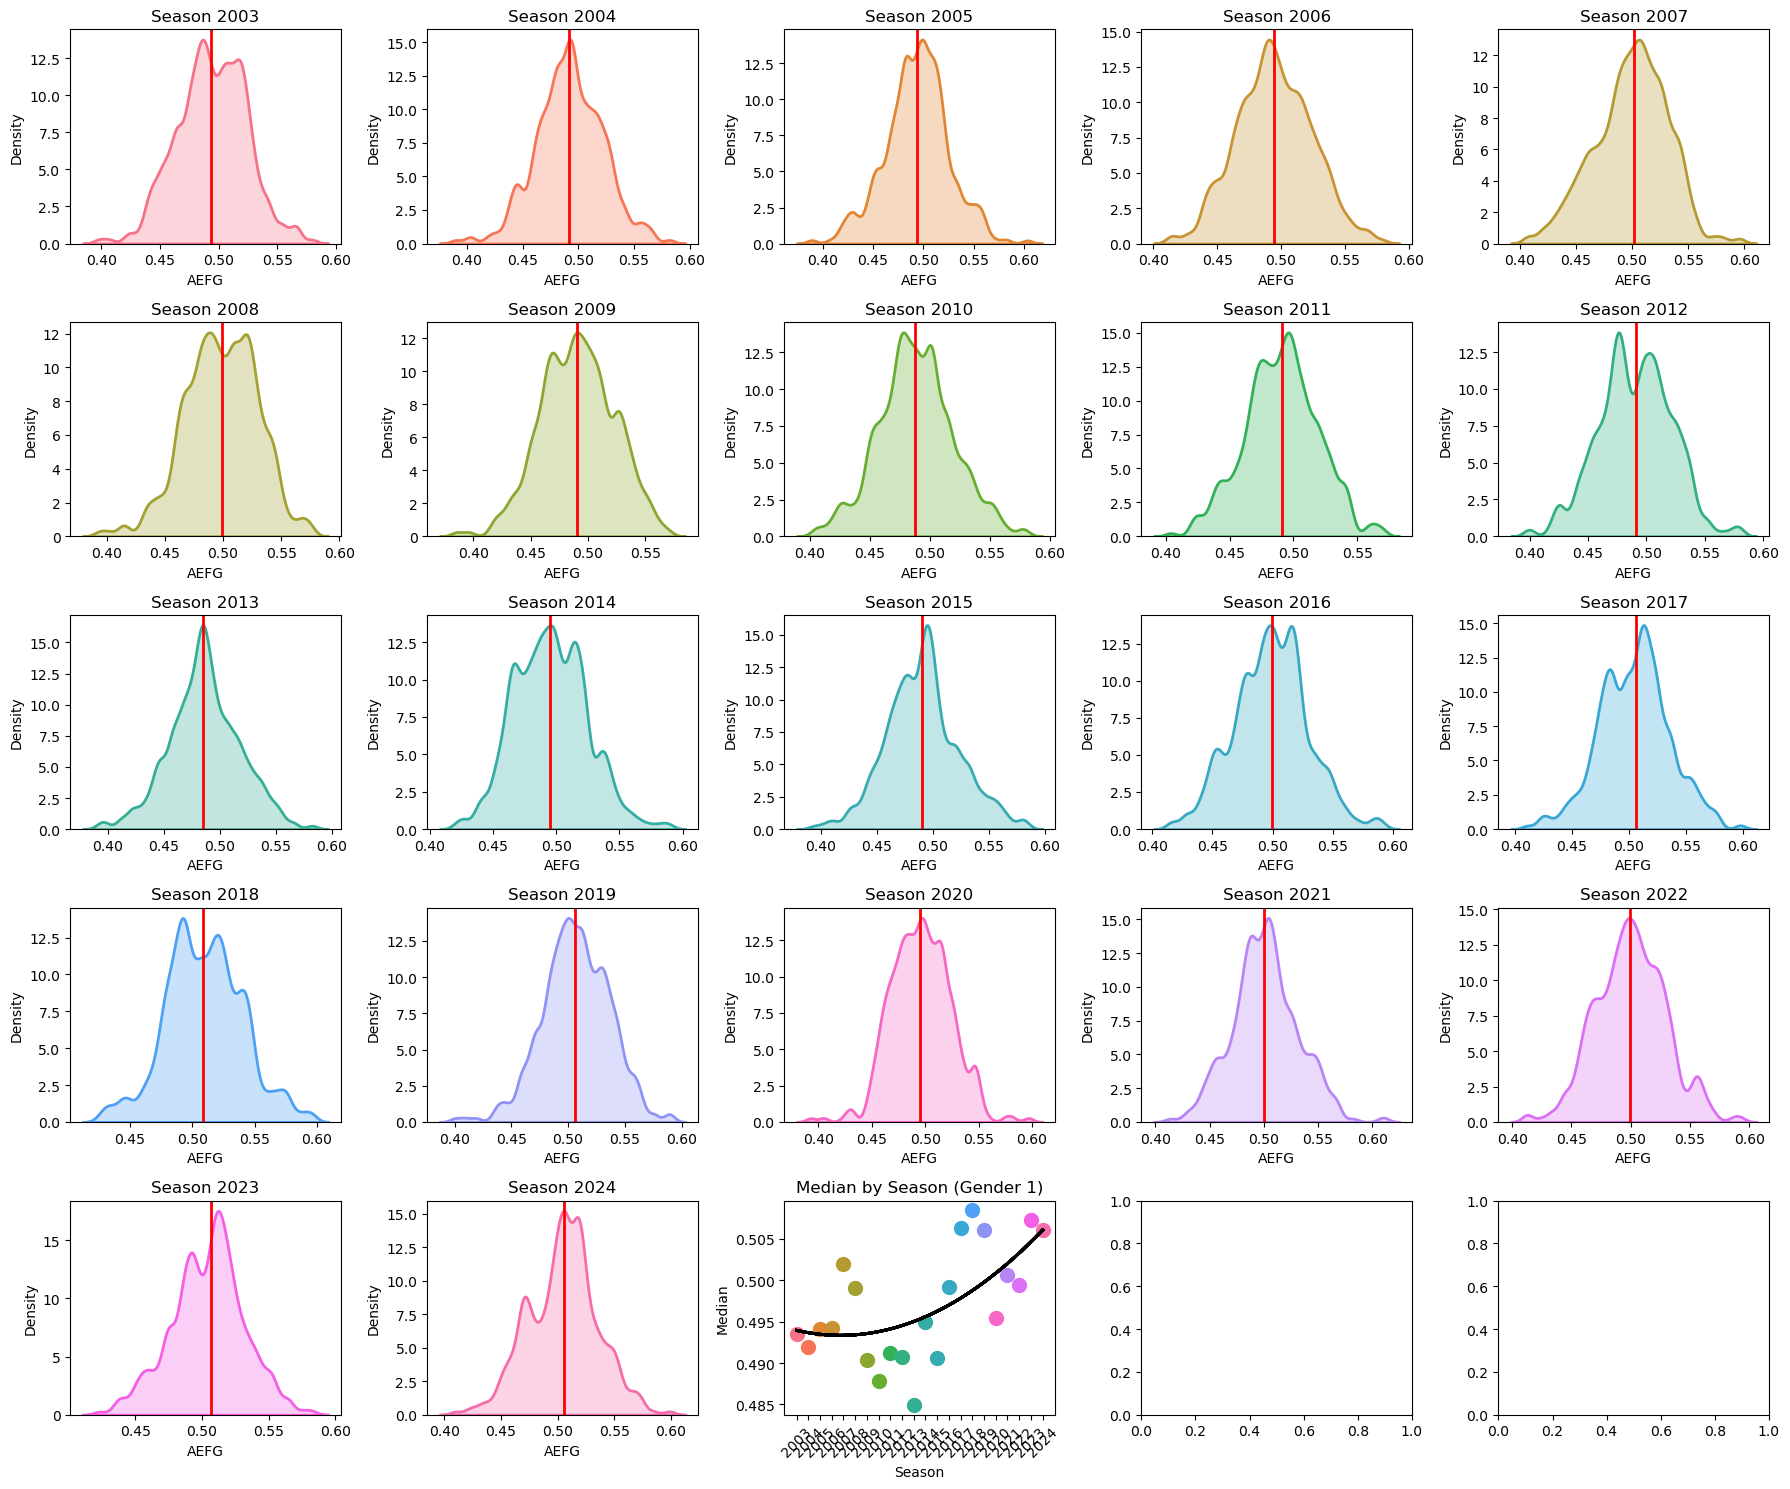

In [93]:
column_name = "AEFG"
n_seasons = len(df[df["Gender"] == 1]["Season"].unique())
n_rows = (n_seasons + 4) // 5
palette = sns.color_palette("husl", n_seasons)
season_color = {val: palette[i] for i, val in enumerate(df[df["Gender"] == 1]["Season"].unique())}

fig, axes = plt.subplots(nrows=n_rows, ncols=5, figsize=(18, 3 * n_rows))

for i, (season, data) in enumerate(df[df["Gender"] == 1].groupby("Season")):
    row = i // 5
    col = i % 5
    sns.kdeplot(data=data, x=column_name, fill=True, alpha=0.3, linewidth=2, color=season_color[season], ax=axes[row, col])
    axes[row, col].axvline(data[column_name].median(), color="red", linewidth=2)
    axes[row, col].set_title(f"Season {season}")
    
    # add scatter plot of median
    ax_median = plt.subplot(n_rows, 5, n_seasons + 1)
    ax_median.scatter(season, data[column_name].median(), color=season_color[season], s=100)
    ax_median.set_xlabel("Season")
    ax_median.set_ylabel("Median")
    ax_median.set_xticks(df[df["Gender"] == 1]["Season"].unique())
    ax_median.set_xticklabels(df[df["Gender"] == 1]["Season"].unique(), rotation=45)
    ax_median.set_title("Median by Season (Gender 1)")
    
    # add trendline to median scatter plot
    x = np.array(df[df["Gender"] == 1]["Season"].unique())
    y = np.array([data[column_name].median() for season, data in df[df["Gender"] == 1].groupby("Season")])
    p = np.polyfit(x, y, deg=2)
    f = np.poly1d(p)
    x_new = np.linspace(x[0], x[-1], 100)
    ax_median.plot(x_new, f(x_new), color="black", linewidth=2)
    
fig.tight_layout()
plt.show()

In [94]:
train = df

train_x_col = train[['Season', "Set", 'Gender', 'TeamA', 'TeamB', 'AWRatio', 'BWRatio',
       'AEFG', 'BEFG', 'AOppEFG', 'BOppEFG', 'APPP', 'BPPP', 'AOppPPP',
       'BOppPPP', 'ATS', 'BTS', 'AOppTS', 'BOppTS', "AORTG", "BORTG", "ADRTG", "BDRTG",
       'ATOVPct', 'BTOVPct', 'AOppTOV', 'BOppTOV', 'AORPct', 'BORPct',
       'ADRPct', 'BDRPct', 'AFTR', 'BFTR', 'AOppFTR', 'BOppFTR', "4F",
       'SeedA', 'SeedB']]

train_y_col = train["AWin"]

X_train, X_test, y_train, y_test = train_test_split(train_x_col, train_y_col, test_size=0.3, random_state=random_seed)

In [95]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

In [96]:
k_fold = KFold(n_splits=10, shuffle=True, random_state=random_seed)

In [97]:
scores = {"XGB": {}, "LGBM": {}, "RF": {}, "KNN": {}, "LR": {}, "SGD": {},
          "Average_Ensemble": {}}
importances = {}

In [98]:
xgb_clf = xgboost.XGBClassifier(random_state=random_seed)
brier = cross_val_score(xgb_clf, X_train, y_train, cv=k_fold, n_jobs=1, scoring='neg_brier_score')
brier = np.mean(brier) * -1
xgb_clf.fit(X_train, y_train)
pred_Y = xgb_clf.predict_proba(X_test)
scores["XGB"]["Brier"] = brier
importances["XGB"] = xgb_clf.feature_importances_

In [99]:
score_df = pd.DataFrame.from_dict(scores).T
importances_df = pd.DataFrame.from_dict(importances)
importances_df.index = X_train.columns
importances_df['mean_importance'] = importances_df.mean(axis=1)
importances_df = importances_df.sort_values(by='XGB', ascending=False)

In [100]:
print(score_df)
print(importances_df)

                     Brier
XGB               0.175866
LGBM                   NaN
RF                     NaN
KNN                    NaN
LR                     NaN
SGD                    NaN
Average_Ensemble       NaN
              XGB  mean_importance
AWRatio  0.308083         0.308083
BWRatio  0.278278         0.278278
SeedB    0.053569         0.053569
SeedA    0.049706         0.049706
BPPP     0.019383         0.019383
APPP     0.016329         0.016329
BOppTS   0.013196         0.013196
AOppTS   0.012843         0.012843
AOppEFG  0.012073         0.012073
TeamB    0.011666         0.011666
TeamA    0.011567         0.011567
BOppPPP  0.011339         0.011339
BTOVPct  0.011136         0.011136
BOppEFG  0.010913         0.010913
ATOVPct  0.010649         0.010649
BEFG     0.010530         0.010530
BOppFTR  0.010480         0.010480
AOppFTR  0.010376         0.010376
AOppPPP  0.010351         0.010351
BORPct   0.010248         0.010248
AOppTOV  0.009965         0.009965
ADRPct   0.009

In [101]:
sample = pd.read_csv("/kaggle/input/march-machine-learning-mania-2023/SampleSubmission2023.csv")
sample['Season'] = sample['ID'].apply(lambda x: int(x.split('_')[0]))
sample['TeamA'] = sample['ID'].apply(lambda x: int(x.split('_')[1]))
sample['TeamB'] = sample['ID'].apply(lambda x: int(x.split('_')[2]))

sample["Season"] = sample.Season.astype("int")
sample["TeamA"] = sample.TeamA.astype("int")
sample["TeamB"] = sample.TeamB.astype("int")

In [102]:
sample = sample.merge(men_seeds[['Season', 'Seed', 'TeamID']], how='left', left_on=['Season', 'TeamA'], right_on=['Season', 'TeamID']).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedA'}).fillna(0)
sample = sample.merge(men_seeds[['Season', 'Seed', 'TeamID']], how='left', left_on=['Season', 'TeamB'], right_on=['Season', 'TeamID']).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedB'}).fillna(0)

In [103]:
sample = pd.merge(sample, df[["Season", "TeamA", "Gender", "AWRatio", "AEFG", "AOppEFG", "APPP", "AOppPPP", "ATS", "AOppTS", "AORTG", "ADRTG", "ATOVPct", "AOppTOV", "AORPct", "ADRPct", "AFTR", "AOppFTR"]].groupby(["Season", "TeamA"]).mean(), on=["Season", "TeamA"], how="left")
sample = pd.merge(sample, df[["Season", "TeamB", "BWRatio", "BEFG", "BOppEFG", "BPPP", "BOppPPP", "BTS", "BOppTS", "BORTG", "BDRTG", "BTOVPct", "BOppTOV", "BORPct", "BDRPct", "BFTR", "BOppFTR"]].groupby(["Season", "TeamB"]).mean(), on=["Season", "TeamB"], how="left")

sample["Set"] = 0
sample[["Gender", "AWRatio", "AEFG", "AOppEFG", "APPP", "AOppPPP", "ATS", "AOppTS", "AORTG", "ADRTG", "ATOVPct", "AOppTOV", "AORPct", "ADRPct", "AFTR", "AOppFTR", "TeamB", "BWRatio", "BEFG", "BOppEFG", "BPPP", "BOppPPP", "BTS", "BOppTS", "BORTG", "BDRTG", "BTOVPct", "BOppTOV", "BORPct", "BDRPct", "BFTR", "BOppFTR"]] = sample[["Gender", "AWRatio", "AEFG", "AOppEFG", "APPP", "AOppPPP", "ATS", "AOppTS", "AORTG", "ADRTG", "ATOVPct", "AOppTOV", "AORPct", "ADRPct", "AFTR", "AOppFTR", "TeamB", "BWRatio", "BEFG", "BOppEFG", "BPPP", "BOppPPP", "BTS", "BOppTS", "BORTG", "BDRTG", "BTOVPct", "BOppTOV", "BORPct", "BDRPct", "BFTR", "BOppFTR"]].fillna(sample[["Gender", "AWRatio", "AEFG", "AOppEFG", "APPP", "AOppPPP", "ATS", "AOppTS", "AORTG", "ADRTG", "ATOVPct", "AOppTOV", "AORPct", "ADRPct", "AFTR", "AOppFTR", "TeamB", "BWRatio", "BEFG", "BOppEFG", "BPPP", "BOppPPP", "BTS", "BOppTS", "BORTG", "BDRTG", "BTOVPct", "BOppTOV", "BORPct", "BDRPct", "BFTR", "BOppFTR"]].mean())

In [104]:
sample[["Season", "TeamB", "TeamA", "SeedA", "SeedB", "Gender", "Set"]] = sample[["Season", "TeamB", "TeamA", "SeedA", "SeedB", "Gender", "Set"]].astype(int)
sample["4fODiff"] = (0.4 * (sample["AEFG"] - sample["BEFG"])) - (0.25 * (sample["ATOVPct"] - sample["BTOVPct"])) + (0.2 * (sample["AORPct"] - sample["BORPct"])) + (0.15 * (sample["AFTR"] - sample["BFTR"]))
sample["4fDDiff"] = -(0.4 * (sample["AOppEFG"] - sample["BOppEFG"])) + (0.25 * (sample["AOppTOV"] - sample["BOppTOV"])) + (0.2 * (sample["ADRPct"] - sample["BDRPct"])) - (0.15 * (sample["AOppFTR"] - sample["BOppFTR"]))
sample["4F"] = sample["4fODiff"] - sample["4fDDiff"]
sample.drop(["4fODiff", "4fDDiff"], axis=1, inplace=True)
sample = sample[['Season', "Set", 'Gender', 'TeamA', 'TeamB', 'AWRatio', 'BWRatio',
       'AEFG', 'BEFG', 'AOppEFG', 'BOppEFG', 'APPP', 'BPPP', 'AOppPPP',
       'BOppPPP', 'ATS', 'BTS', 'AOppTS', 'BOppTS', 'AORTG', 'BORTG', 'ADRTG',
       'BDRTG', 'ATOVPct', 'BTOVPct', 'AOppTOV', 'BOppTOV', 'AORPct', 'BORPct',
       'ADRPct', 'BDRPct', 'AFTR', 'BFTR', 'AOppFTR', 'BOppFTR', "4F",
       'SeedA', 'SeedB']]

In [105]:
sample = pd.DataFrame(scaler.transform(sample), columns=sample.columns, index=sample.index)

In [106]:
sample_final = pd.read_csv("/kaggle/input/march-machine-learning-mania-2023/SampleSubmission2023.csv")
sub_pred = xgb_clf.predict_proba(sample).astype(float)
sub_pred = sub_pred[:, 1]
sample_final['Pred'] = sub_pred
sample_final.to_csv("xgb1.csv", index = False)

In [107]:
print(sample_final)

                    ID      Pred
0       2023_1101_1102  0.318237
1       2023_1101_1103  0.100329
2       2023_1101_1104  0.003929
3       2023_1101_1105  0.542483
4       2023_1101_1106  0.874362
...                ...       ...
130678  2023_3474_3476  0.466606
130679  2023_3474_3477  0.466606
130680  2023_3475_3476  0.466606
130681  2023_3475_3477  0.466606
130682  2023_3476_3477  0.466606

[130683 rows x 2 columns]


In [108]:
sample_final[['year', 'team_a', 'team_b']] = sample_final['ID'].str.split('_', expand=True)

sample_final['is_team_a_win'] = (sample_final['Pred'] >= 0.5).astype(int)

final_df = sample_final[['team_a', 'team_b', 'is_team_a_win']]

print(final_df)

       team_a team_b  is_team_a_win
0        1101   1102              0
1        1101   1103              0
2        1101   1104              0
3        1101   1105              1
4        1101   1106              1
...       ...    ...            ...
130678   3474   3476              0
130679   3474   3477              0
130680   3475   3476              0
130681   3475   3477              0
130682   3476   3477              0

[130683 rows x 3 columns]


In [109]:
import pandas as pd

tourney_seeds = pd.read_csv('/kaggle/input/march-machine-learning-mania-2024/2024_tourney_seeds.csv')

tourney_teams = tourney_seeds[tourney_seeds['Tournament'] == 'M']['TeamID']

final_df['team_a'] = pd.to_numeric(final_df['team_a'])
final_df['team_b'] = pd.to_numeric(final_df['team_b'])

filtered_final_df = final_df[(final_df['team_a'].isin(tourney_teams)) & (final_df['team_b'].isin(tourney_teams))]

print(filtered_final_df)


       team_a  team_b  is_team_a_win
723      1103    1104              0
730      1103    1112              0
737      1103    1120              0
740      1103    1124              0
744      1103    1129              0
...       ...     ...            ...
65187    1443    1458              0
65192    1443    1463              0
65332    1450    1458              0
65337    1450    1463              0
65517    1458    1463              0

[2016 rows x 3 columns]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [110]:
mirror_df = filtered_final_df.copy()
mirror_df['team_a'], mirror_df['team_b'] = mirror_df['team_b'], mirror_df['team_a']  
mirror_df['is_team_a_win'] = 1 - mirror_df['is_team_a_win'] 

combined_df_corrected = pd.concat([filtered_final_df, mirror_df]).reset_index(drop=True)

print(combined_df_corrected)

      team_a  team_b  is_team_a_win
0       1103    1104              0
1       1103    1112              0
2       1103    1120              0
3       1103    1124              0
4       1103    1129              0
...      ...     ...            ...
4027    1458    1458              1
4028    1463    1463              1
4029    1458    1458              1
4030    1463    1463              1
4031    1463    1463              1

[4032 rows x 3 columns]
